# Testing Adaptation

In [1]:
import sys
sys.path.append("")

import os, shutil
import os.path as osp
import pickle
import json
import numpy as np
import click
import torch

import pyglet
from tensorboardX import SummaryWriter
import datetime

from envs.metaENV import ENV, VisualiserWrapper
from envs.MetaPeg2D import WINDOW_X, WINDOW_Y, ORIGIN, PEG_DEPTH
from backend.torch.PEARL.policies import TanhGaussianPolicy
from backend.torch.networks import FlattenMlp, MlpEncoder, RecurrentEncoder, LatentGNNEncoder, NormalAux
from backend.torch.PEARL.agent import PEARLAgent

from experiment import deep_update_dict
from backend.torch.PEARL.policies import MakeDeterministic
from backend.samplers.util import rollout, rollout_window
from configs.default import default_config

def run_sim_path(task_idx, trial, path, framework = 'PEARL'):
    env = VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", vsync = False, 
                            resizable = False, visible = False)
    env.show = False
    env.reset_task(task_idx)
    env.set_task_idx(task_idx)
    print(f'Adapting to task {task_idx} on trial {trial}')
    env.run_path(path)
    print('DONE ... \n')
    
def sim_policy(variant, 
               path_to_exp, 
               num_trajs=1, 
               deterministic=False, 
               sparse_rewards = False, 
               view=False, 
               continuous = False,
               visible = False
              ):
    '''
    simulate a trained policy adapting to a new task
    optionally save videos of the trajectories - requires ffmpeg
    :variant: experiment configuration dict
    :path_to_exp: path to exp folder
    :num_trajs: number of trajectories to simulate per task (default 1)
    :deterministic: if the policy is deterministic (default stochastic)
    :save_video: whether to generate and save a video (default False)
    '''

    env = ENV() if not view else VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", 
                                                   vsync = False, resizable = False, visible = visible)
    env.show = view
    tasks = env.get_all_task_idx()
    obs_dim = int(np.prod(env.observation_space.shape))
    action_dim = int(np.prod(env.action_space.shape))
    reward_dim = 1    

    eval_tasks=list(tasks[-variant['n_eval_tasks']:])
    print('testing on {} test tasks, {} trajectories each'.format(len(eval_tasks), num_trajs))

    # instantiate networks
    latent_dim = variant['latent_size']
    context_encoder_input_dim = 2 * obs_dim + action_dim + reward_dim if variant['algo_params']['use_next_obs_in_context'] else obs_dim + action_dim + reward_dim
    context_encoder_output_dim = latent_dim * 2 if variant['algo_params']['use_information_bottleneck'] else latent_dim    
    net_size = variant['net_size']
    recurrent = variant['algo_params']['recurrent']
    encoder_model = RecurrentEncoder if recurrent else MlpEncoder

    if not variant['GNN_encoder']:
        context_encoder = encoder_model(
            hidden_sizes=[128, 128, 128], 
            input_size=context_encoder_input_dim,
            output_size=context_encoder_output_dim,
        )
    else:
        context_encoder = LatentGNNEncoder(
                        input_dim= context_encoder_input_dim,
                        output_size = context_encoder_output_dim,
                        **variant['LatentGNN']
        )
    if variant['aux_loss']:
        aux_decoder = NormalAux(
            hidden_sizes = variant['aux_params']['hidden'],
            input_size = latent_dim,
            output_size = variant['aux_params']['belief_dim'],
            std = variant['aux_params']['aux_std']
        )
    policy = TanhGaussianPolicy(
        hidden_sizes=[net_size, net_size, net_size],
        obs_dim=obs_dim + latent_dim,
        latent_dim=latent_dim,
        action_dim=action_dim,
    )
    agent = PEARLAgent(
        policy,
        context_encoder=context_encoder,
        aux_decoder=aux_decoder,
        aux_params = variant['aux_params'],
        latent_dim=latent_dim,
        **variant['algo_params']
    )
    
    # deterministic eval
    if deterministic:
        agent = MakeDeterministic(agent)

    # load trained weights (otherwise simulate random policy)
    context_encoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'context_encoder.pth')))
    policy.load_state_dict(torch.load(os.path.join(path_to_exp, 'policy.pth')))
    if aux_decoder is not None:
        aux_decoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'aux_decoder.pth')))

    if view:
        env.set_visible(visible = visible)
        env.set_visibles()
        
    max_steps = 200
    context_window_length = 20
    
    # loop through tasks collecting rollouts
    all_rets = []
    all_paths = []
    for idx in eval_tasks:
        env.set_task_idx(idx)
        env.reset_task(idx)
        env.rollout_counter = 0
        agent.clear_z()
        paths = []
        if not continuous:
            for n in range(num_trajs):
                if view:
                    print(f'Adapting to task {idx} on trial {n}')
                    env.view_rollout(agent, accum_context = True, max_steps = variant['algo_params']['max_path_length'],
                                    sparse_rewards = sparse_rewards)
                    env.reset_task(idx)
                else:
                    path = rollout(env, agent, max_path_length=variant['algo_params']['max_path_length'], 
                                   accum_context=True, sparse_rewards = sparse_rewards)
                    if n >= variant['algo_params']['num_exp_traj_eval']:
                        agent.infer_posterior(agent.context)
                    paths.append(path)
            env.all_paths.append(env.trajectories)
        else:
            if view:
                env.view_rollout(agent, accum_context = True, max_steps = max_steps, 
                                 continuous_update = continuous, sparse_rewards = sparse_rewards)#,
#                                 context_window_length = variant['algo_params']['context_window_steps'])
                env.reset_task(idx)
                env.all_paths.append(env.trajectories)
            else:
                path = rollout_window(env, agent, max_path_length = max_steps, context_window_length = context_window_length, accum_context= True, animated = view)

        all_rets.append([sum(p['rewards']) for p in paths])
#         all_paths.append(paths)

#         if view:
#             for n in range(num_trajs):
#                 run_sim_path(idx, n, paths[n])
                
    # compute average returns across tasks
    if not view:
        n = min([len(a) for a in all_rets])
        rets = [a[:n] for a in all_rets]
        rets = np.mean(np.stack(rets), axis=0)
        for i, ret in enumerate(rets):
            print('trajectory {}, avg return: {} \n'.format(i, ret))

    return env.all_paths 

def main(config, path, num_trajs = 5, deterministic = False, sparse_rewards = False, 
         view = False, continuous = False, visible = False):
    variant = default_config
    if config:
        with open(osp.join(config)) as f:
            exp_params = json.load(f)
        variant = deep_update_dict(exp_params, variant)
    variant['util_params']['use_gpu']
    return sim_policy(variant, path, num_trajs, deterministic, sparse_rewards, view, continuous, visible = visible)

if __name__ == "__main__":
    config = None
    num_trajs = 4
    path = "output/Peg2D/2020_07_20_17_56_19"
    # 2020_07_08_15_51_03
#     all_paths_traj_sparse = main(config, path, num_trajs, 
#                      deterministic = False, 
#                      sparse_rewards = True, 
#                      view = True, 
#                      continuous= False,
#                      visible = True)
    
    all_paths_cont_sparse = main(config, path, num_trajs, 
                 deterministic = False, 
                 sparse_rewards = True, 
                 view = True, 
                 continuous= True,
                 visible = True)
    
#     all_paths_cont = main(config, path, num_trajs, 
#                  deterministic = False, 
#                  sparse_rewards = False, 
#                  view = True, 
#                  continuous= True,
#                  visible = False)

Loading chipmunk for Windows (64bit) [C:\Users\Alvaro\Anaconda3\lib\site-packages\pymunk\chipmunk.dll]
testing on 10 test tasks, 4 trajectories each


C:\Users\Alvaro\Anaconda3\lib\site-packages\torch\cuda\__init__.py:135: UserWarning: 
    Found GPU0 GeForce GT 750M which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Updating continuous belief at traj 0 and roll 0
Updating continuous belief at traj 20 and roll 20
Updating continuous belief at traj 40 and roll 40
Updating continuous belief at traj 60 and roll 60
Updating continuous belief at traj 80 and roll 80
Updating continuous belief at traj 100 and roll 100
Updating continuous belief at traj 120 and roll 120
Updating continuous belief at traj 140 and roll 140
Updating continuous belief at traj 160 and roll 160
Updating continuous belief at traj 180 and roll 180
Ending Task ... 

Updating continuous belief at traj 0 and roll 0
Updating continuous belief at traj 20 and roll 20
Updating continuous belief at traj 40 and roll 40
Updating continuous belief at traj 60 and roll 60
Updating continuous belief at traj 80 and roll 80
Updating continuous belief at traj 100 and roll 100
Updating continuous belief at traj 120 and roll 120
Updating continuous belief at traj 140 and roll 140
Updating continuous belief at traj 160 and roll 160
Updating continuou

# Evaluation

In [4]:
from eval_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from envs.MetaPeg2D import norm_pos, denorm_pos

In [48]:
[len(all_paths_traj[x]) for x in range(len(all_paths_traj))]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [75]:
[len(all_paths_traj_sparse[x]) for x in range(len(all_paths_traj_sparse))]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [76]:
[[x['rollout_length'] for x in all_paths_traj[y]] for y in range(len(all_paths_traj))]

[[50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 41, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [34, 35, 47, 50]]

In [77]:
[[x['rollout_length'] for x in all_paths_traj_sparse[y]] for y in range(len(all_paths_traj_sparse))]

[[50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50],
 [50, 50, 50, 50]]

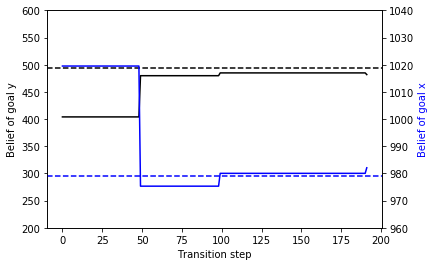

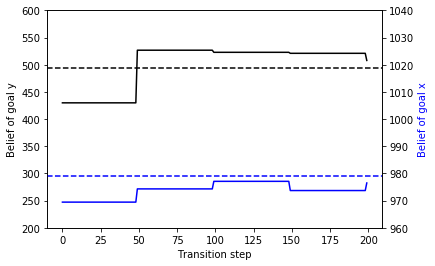

In [50]:
belief_plot(all_paths_traj[3])
plt.figure()
belief_plot(all_paths_traj_sparse[3])

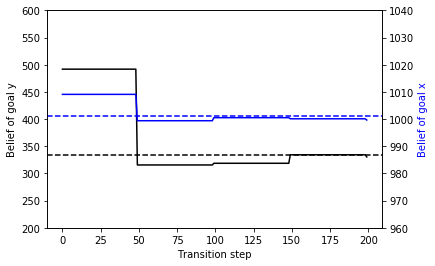

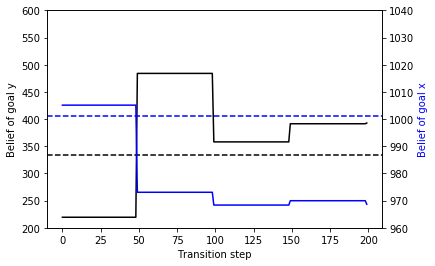

In [51]:
belief_plot(all_paths_traj[6])
plt.figure()
belief_plot(all_paths_traj_sparse[6])

In [78]:
[len(all_paths_cont[x]) for x in range(len(all_paths_cont))]

[1, 1, 1, 2, 1, 3, 1, 1, 1, 5]

In [2]:
[len(all_paths_cont_sparse[x]) for x in range(len(all_paths_cont_sparse))]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [67]:
[[x['rollout_length'] for x in all_paths_cont[y]] for y in range(len(all_paths_cont))]

[[200],
 [200],
 [200],
 [57, 143],
 [200],
 [200],
 [200],
 [200],
 [143, 57],
 [48, 152]]

In [82]:
[[x['rollout_length'] for x in all_paths_cont_sparse[y]] for y in range(len(all_paths_cont_sparse))]

[[200], [200], [200], [200], [200], [200], [200], [200], [200], [200]]

In [3]:
belief_plot(all_paths_cont[9])
plt.figure()
belief_plot(all_paths_cont_sparse[9])

NameError: name 'belief_plot' is not defined

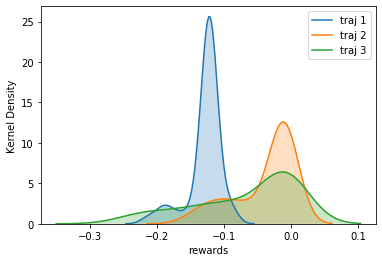

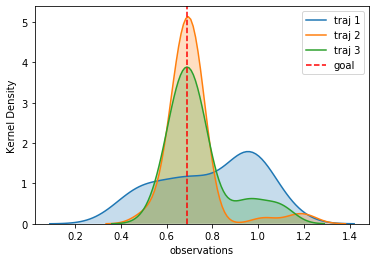

In [86]:
traj_histo(all_paths_traj[1][:3], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj[1][:3], param = 'observations', var_idx=1)

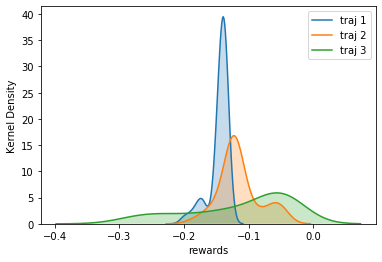

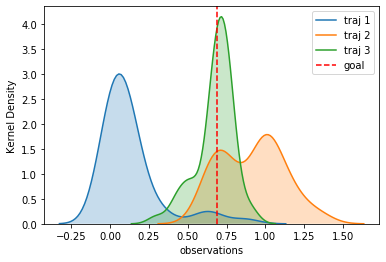

In [87]:
traj_histo(all_paths_traj_sparse[1][:3], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj_sparse[1][:3], param = 'observations', var_idx=1)

In [76]:
traj_histo(all_paths_cont[3], param = 'rewards')
plt.figure()
traj_histo(all_paths_cont[3], param = 'observations', var_idx=1)

NameError: name 'sns' is not defined

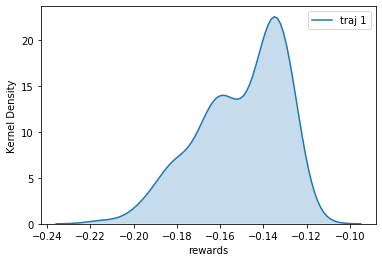

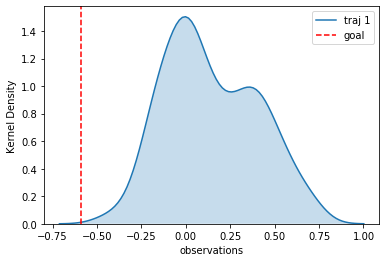

In [5]:
traj_histo(all_paths_cont_sparse[2], param = 'rewards')
plt.figure()
traj_histo(all_paths_cont_sparse[2], param = 'observations', var_idx=1)

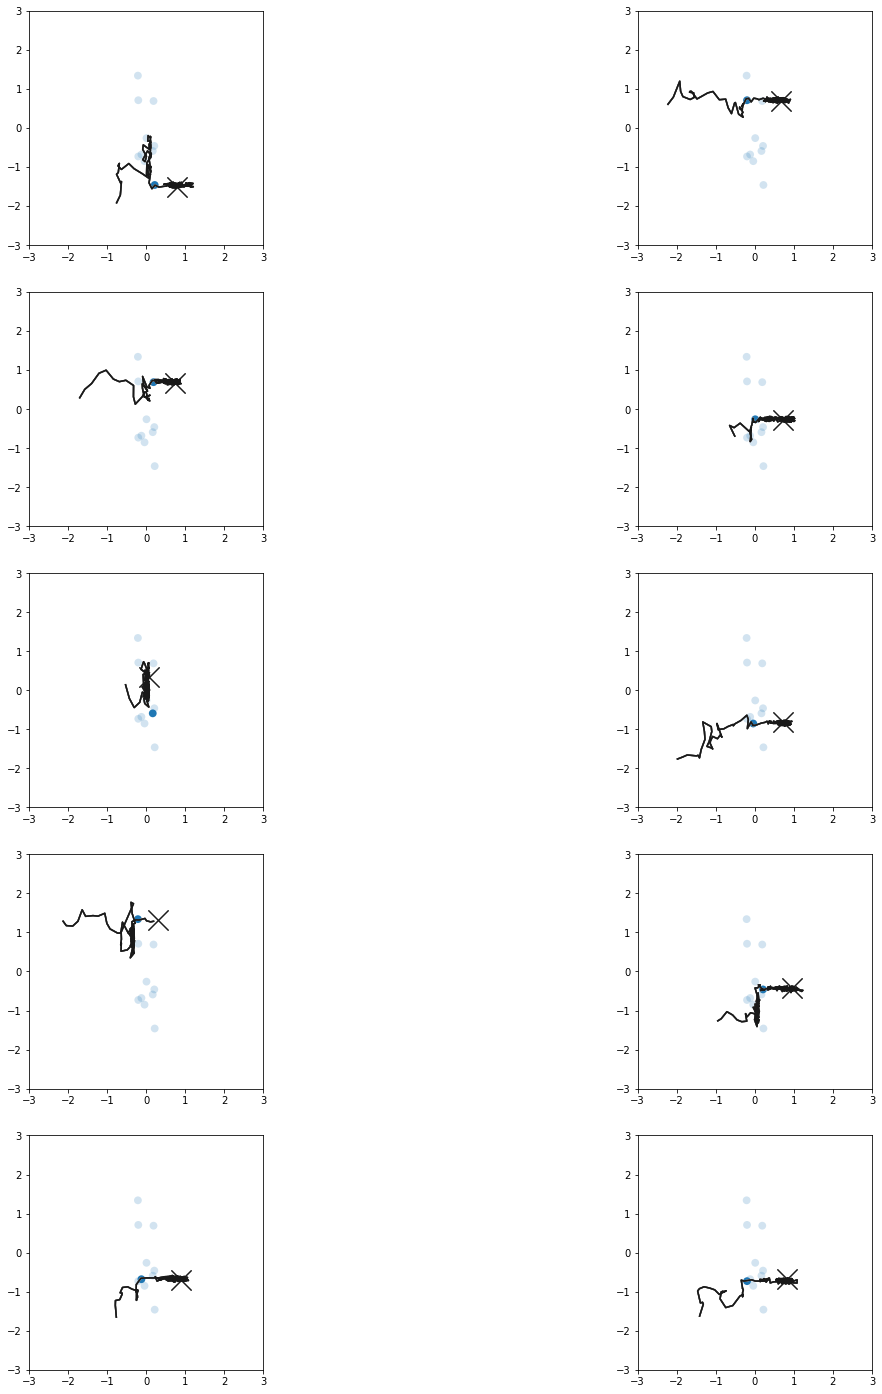

In [6]:
plot_trajectories(all_paths = all_paths_cont_sparse, num_trajs = 6)

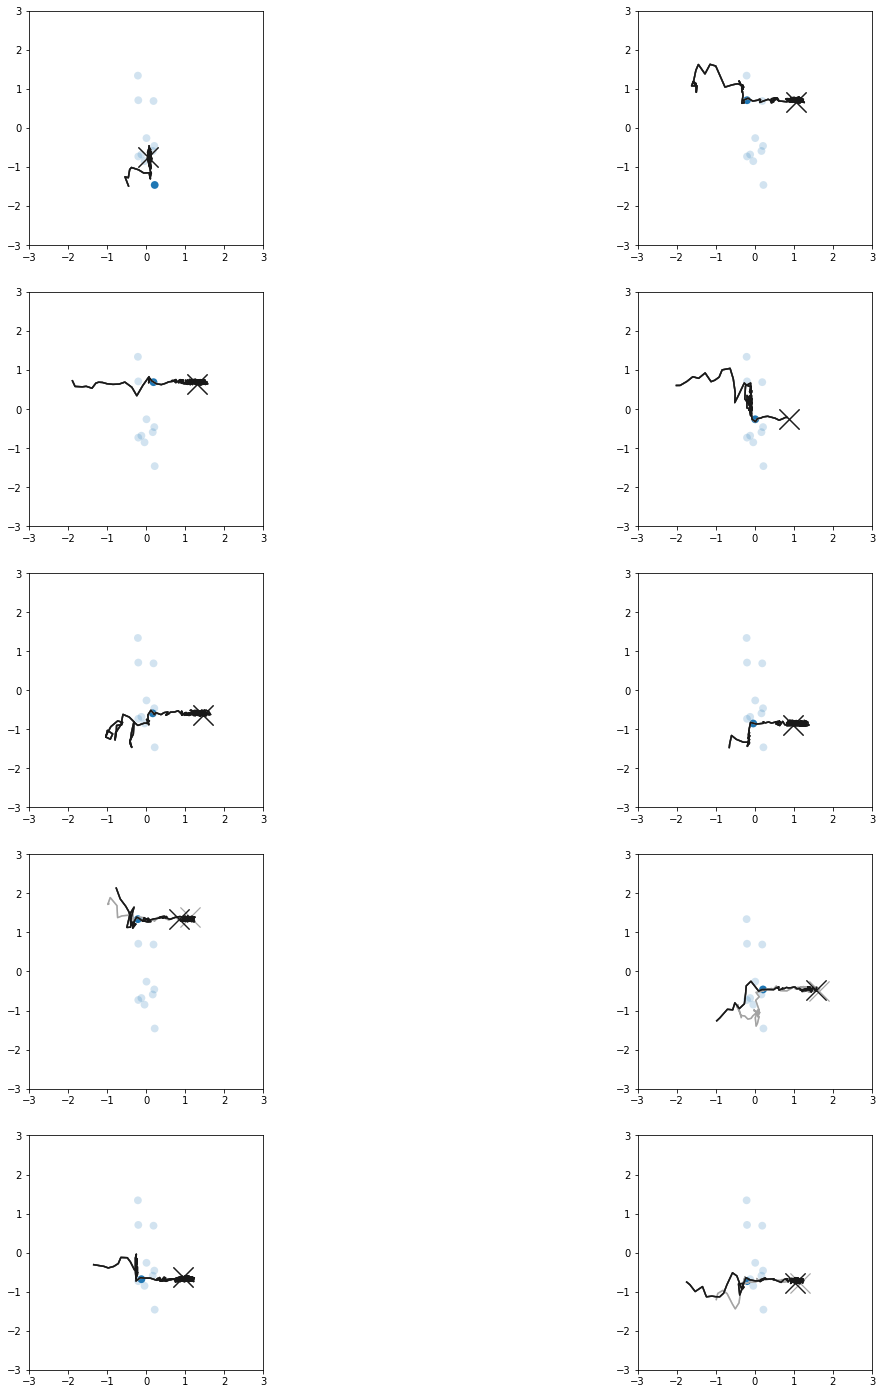

In [77]:
plot_trajectories(all_paths = all_paths_cont, num_trajs = 6)

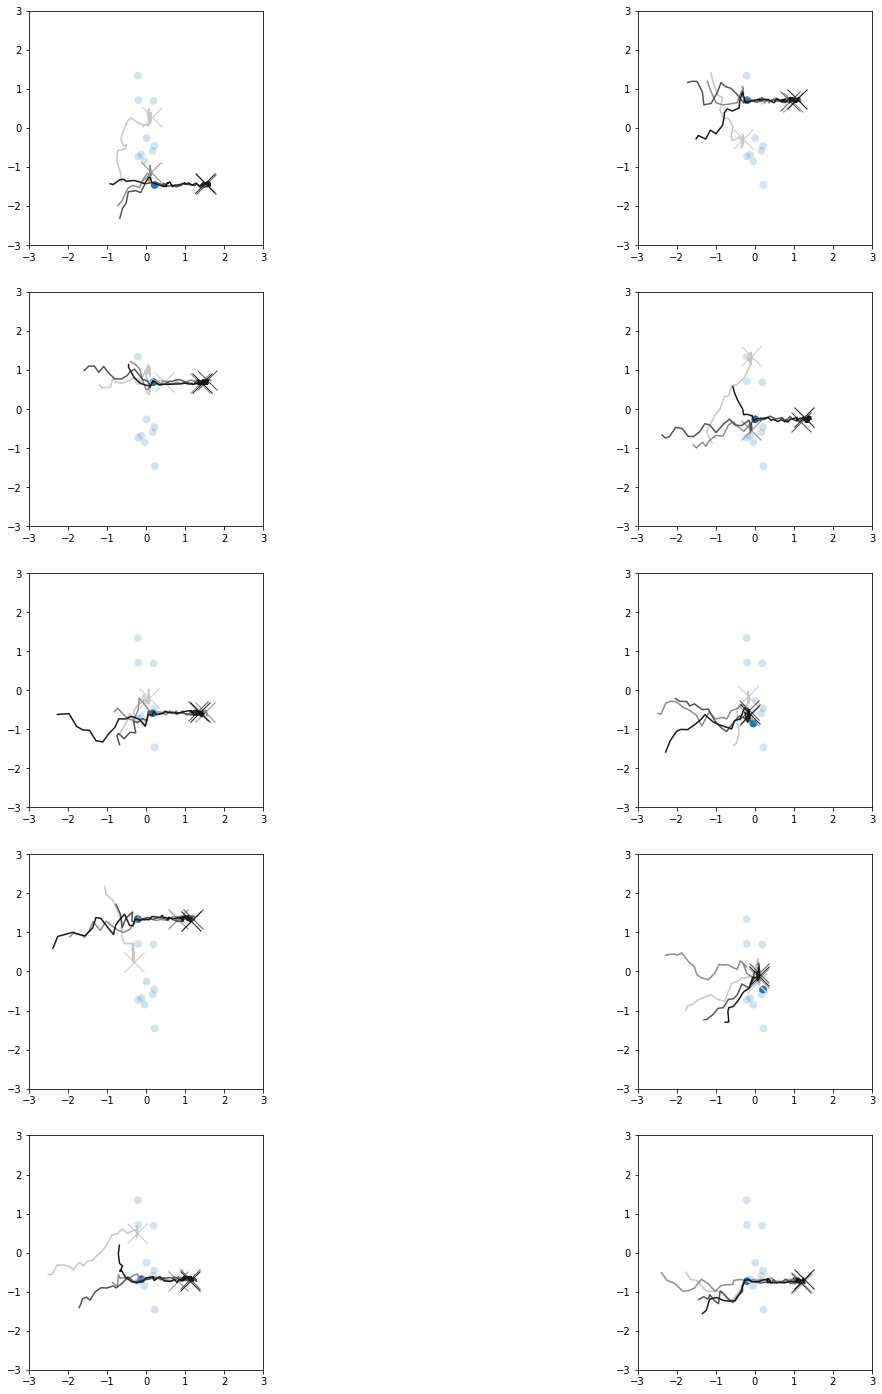

In [92]:
plot_trajectories(all_paths = all_paths_traj, num_trajs = 5)

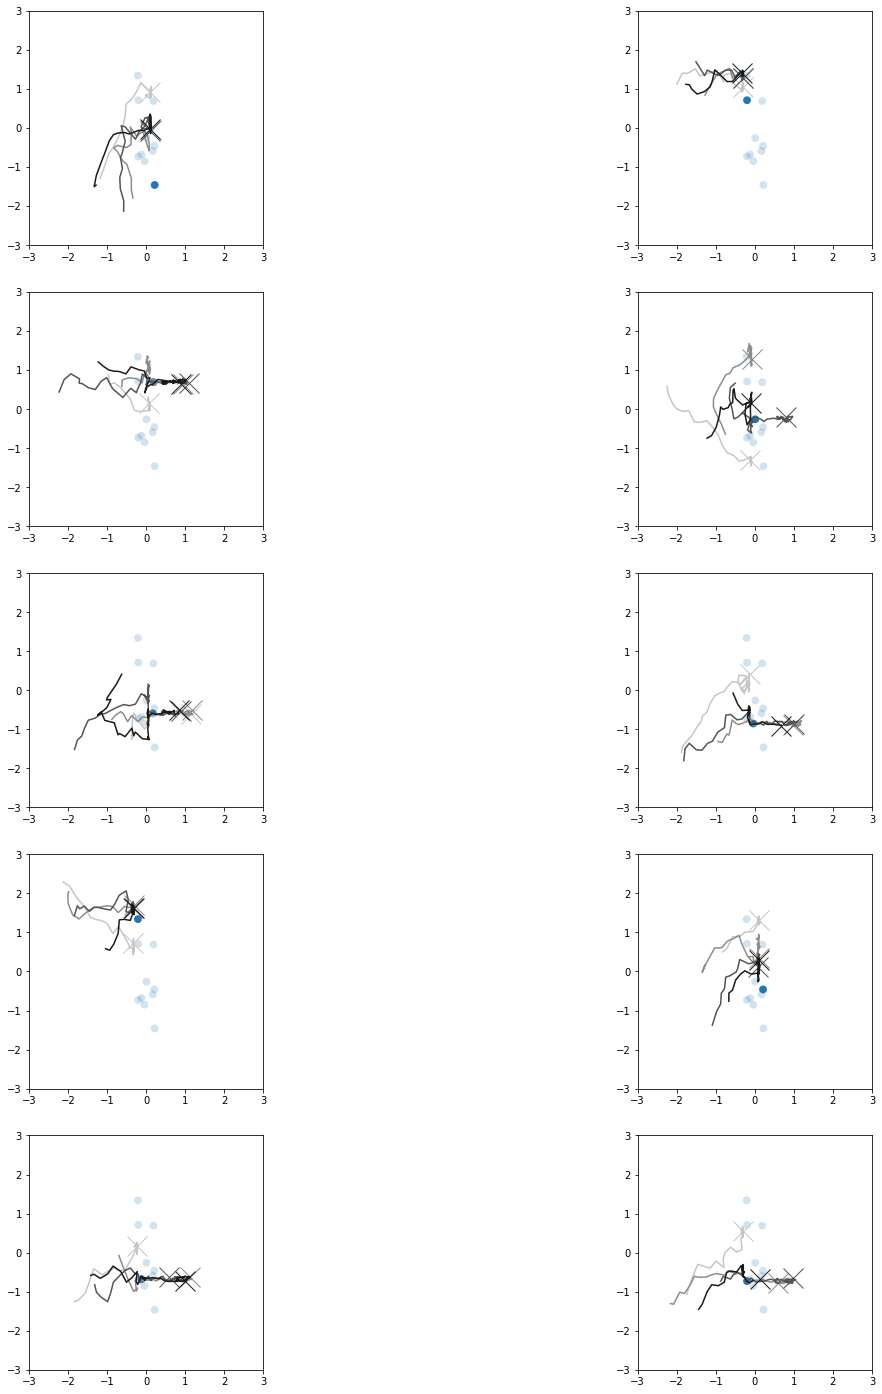

In [104]:
plot_trajectories(all_paths = all_paths_traj_sparse, num_trajs = 5)

## Task finder

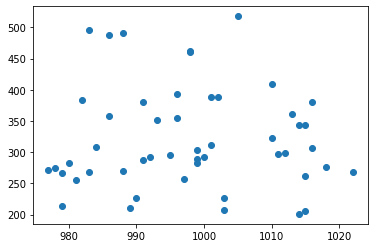

In [62]:
import numpy as np
listt = []
goal_x = np.random.randint(975, 1025,50)
goal_y = np.random.randint(200, 520, 50)
zip(goal_x, goal_y)
for x,y in zip(goal_x, goal_y):
    listt.append(Vec2d(x,y))
import matplotlib.pyplot as plt
plt.figure()
plt.scatter([x[0] for x in listt], [x[1] for x in listt])
plt.show()

In [63]:
listt

[Vec2d(1018, 276),
 Vec2d(995, 295),
 Vec2d(986, 358),
 Vec2d(1015, 344),
 Vec2d(982, 383),
 Vec2d(1005, 518),
 Vec2d(980, 283),
 Vec2d(991, 380),
 Vec2d(999, 303),
 Vec2d(999, 289),
 Vec2d(1014, 344),
 Vec2d(978, 274),
 Vec2d(999, 283),
 Vec2d(991, 287),
 Vec2d(993, 352),
 Vec2d(1002, 389),
 Vec2d(986, 488),
 Vec2d(989, 210),
 Vec2d(1015, 206),
 Vec2d(1000, 292),
 Vec2d(979, 267),
 Vec2d(998, 463),
 Vec2d(1013, 362),
 Vec2d(996, 393),
 Vec2d(979, 214),
 Vec2d(1011, 297),
 Vec2d(988, 491),
 Vec2d(998, 461),
 Vec2d(1016, 307),
 Vec2d(992, 293),
 Vec2d(1003, 227),
 Vec2d(1003, 208),
 Vec2d(1010, 322),
 Vec2d(1001, 311),
 Vec2d(977, 272),
 Vec2d(988, 270),
 Vec2d(997, 257),
 Vec2d(1022, 268),
 Vec2d(984, 309),
 Vec2d(983, 496),
 Vec2d(1014, 201),
 Vec2d(1015, 261),
 Vec2d(996, 355),
 Vec2d(990, 226),
 Vec2d(983, 269),
 Vec2d(981, 255),
 Vec2d(1012, 298),
 Vec2d(1010, 409),
 Vec2d(1001, 389),
 Vec2d(1016, 381)]

In [106]:
ast = ad = af = 0

In [107]:
ast

0

In [109]:
ad

0

In [135]:
a = [0,9,8]
a.append(["hello", 9])
a

[0, 9, 8, ['hello', 9]]

In [136]:
b = ['he', 'lo']


In [129]:
a = set([0,1,8])
b = set([0,1])

In [132]:
a.issuperset(b)

True

In [133]:
a = [0,1,2,3]
a[1:4]

[1, 2, 3]

In [137]:
(a+b)

[0, 9, 8, ['hello', 9], 'he', 'lo']

In [156]:
# Split into boxes
t = 16
mbs = 8
b = 256
r = torch.rand([16,256,1]).view(t, mbs, b//mbs, -1)
o = torch.rand([16,256,6]).view(t, mbs, b//mbs, -1)
a = torch.rand([16,256,4]).view(t, mbs, b//mbs, -1)
no = torch.rand([16,256,6]).view(t, mbs, b//mbs, -1)
print(r.shape, o.shape, a.shape, no.shape)

torch.Size([16, 8, 32, 1]) torch.Size([16, 8, 32, 6]) torch.Size([16, 8, 32, 4]) torch.Size([16, 8, 32, 6])


In [155]:
for i in range(b):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


In [7]:
a = [torch.FloatTensor(i) for i in range(256)]

In [8]:
torch.cat(a)

tensor([ 1.1729e-42, -2.7696e-29,  4.5915e-41,  ...,  0.0000e+00,
         0.0000e+00,  2.1019e-44])

In [3]:
import torch

In [9]:
a = dict(a=1,
        b=9)

In [11]:
a.values()

dict_values([1, 9])

In [14]:
for k in a:
    print(k*7)

aaaaaaa
bbbbbbb


In [1]:
import time
time.time()

1595245424.4868164

In [3]:
# 2020_07_20_11_50_43
import torch

In [57]:
t = torch.ones((1024,64,12))
get = [m.repeat(4,1,1) for m in t]

In [60]:
len(get[0])

4

In [61]:
tens = torch.cat(get)

In [62]:
tens.shape

torch.Size([4096, 64, 12])

In [54]:
(t[0].repeat(2,1,1)).shape

torch.Size([2, 64, 12])

## Testing Demo Adaptation

In [1]:
import sys
sys.path.append("")

import os, shutil
import os.path as osp
import pickle
import json
import numpy as np
import click
import torch

import pyglet
from tensorboardX import SummaryWriter
import datetime

from envs.metaENV import ENV, VisualiserWrapper
from envs.MetaPeg2D import WINDOW_X, WINDOW_Y, ORIGIN, PEG_DEPTH
from backend.torch.PEARL.policies import TanhGaussianPolicy
from backend.torch.networks import FlattenMlp, MlpEncoder, RecurrentEncoder, LatentGNNEncoder, NormalAux
from backend.torch.PEARL.agent import PEARLAgent
from backend.torch.PEARL.sac import PEARLSoftActorCritic

from experiment import deep_update_dict
from backend.torch.PEARL.policies import MakeDeterministic
from backend.samplers.util import rollout, rollout_window
from configs.default import default_config

def run_sim_path(task_idx, trial, path, framework = 'PEARL'):
    env = VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", vsync = False, 
                            resizable = False, visible = False)
    env.show = False
    env.reset_task(task_idx)
    env.set_task_idx(task_idx)
    print(f'Adapting to task {task_idx} on trial {trial}')
    env.run_path(path)
    print('DONE ... \n')
    
def demo_sim_policy(variant, 
               path_to_exp, 
               num_trajs=1,
               demos = None,
               deterministic=False,  
               visible = False,
               continuous = False,
               randomise_task = False,
              ):
    '''
    simulate a trained policy adapting to a new task
    optionally save videos of the trajectories - requires ffmpeg
    :variant: experiment configuration dict
    :path_to_exp: path to exp folder
    :num_trajs: number of trajectories to simulate per task (default 1)
    :deterministic: if the policy is deterministic (default stochastic)
    :save_video: whether to generate and save a video (default False)
    '''
    view = True

    env = ENV() if not view else VisualiserWrapper(WINDOW_X, WINDOW_Y, "RoboPeg2D Simulation", 
                                                   vsync = False, resizable = False, visible = visible)
    env.show = view
    tasks = env.get_all_task_idx()
    obs_dim = int(np.prod(env.observation_space.shape))
    action_dim = int(np.prod(env.action_space.shape))
    reward_dim = 1    

    eval_tasks=list(tasks[-variant['n_eval_tasks']:])
    print('testing on {} test tasks, {} trajectories each'.format(len(eval_tasks), num_trajs))

    # instantiate networks
    latent_dim = variant['latent_size']
    context_encoder_input_dim = 2 * obs_dim + action_dim + reward_dim if variant['algo_params']['use_next_obs_in_context'] else obs_dim + action_dim + reward_dim
    context_encoder_output_dim = latent_dim * 2 if variant['algo_params']['use_information_bottleneck'] else latent_dim    
    net_size = variant['net_size']

    context_encoder = LatentGNNEncoder(
                    input_dim= context_encoder_input_dim,
                    output_size = context_encoder_output_dim,
                    **variant['LatentGNN']
    )
    if variant['aux_loss']:
        aux_decoder = NormalAux(
            hidden_sizes = variant['aux_params']['hidden'],
            input_size = latent_dim,
            output_size = variant['aux_params']['belief_dim'],
            std = variant['aux_params']['aux_std']
        )
    qf1 = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + action_dim + latent_dim,
        output_size=1,
    )
    qf2 = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + action_dim + latent_dim,
        output_size=1,
    )
    vf = FlattenMlp(
        hidden_sizes=[net_size, net_size, net_size],
        input_size=obs_dim + latent_dim,
        output_size=1,
    )
    policy = TanhGaussianPolicy(
        hidden_sizes=[net_size, net_size, net_size],
        obs_dim=obs_dim + latent_dim,
        latent_dim=latent_dim,
        action_dim=action_dim,
    )
    agent = PEARLAgent(
        policy,
        context_encoder=context_encoder,
        aux_decoder=aux_decoder,
        aux_params = variant['aux_params'],
        latent_dim=latent_dim,
        **variant['algo_params']
    )

    # load trained weights (otherwise simulate random policy)
    context_encoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'context_encoder.pth'), map_location='cpu'))
    policy.load_state_dict(torch.load(os.path.join(path_to_exp, 'policy.pth'),map_location='cpu'))
    if aux_decoder is not None:
        aux_decoder.load_state_dict(torch.load(os.path.join(path_to_exp, 'aux_decoder.pth'),map_location='cpu'))

    nets = [agent, qf1, qf2, vf] 
    nets.append(context_encoder)
    if aux_decoder is not None:
        nets.append(aux_decoder)
    algorithm = PEARLSoftActorCritic(
        env=env,
        train_tasks=list(tasks[:variant['n_train_tasks']]),
        eval_tasks=list(tasks[-variant['n_eval_tasks']:]),
        nets=nets,
        demo_paths=demos,
        decoupled = variant['decoupled_config']['use'],
        **variant['algo_params']
    )
    algorithm.load_demos()   
    
    env.set_visible(visible = visible)
    env.set_visibles()
        
    max_steps = 200
    context_window_length = 25
    
    # loop through tasks collecting rollouts
    all_rets = []
    accum_trajs = True
    use_demos = True
    
    all_paths = []
    for idx in eval_tasks:
        env.set_task_idx(idx)
        env.reset_task(idx)
        if randomise_task:
            env.alter_task()
        env.rollout_counter = 0
        demo_context = algorithm.sample_context(idx, demos = True, batch_size = 32)
        if use_demos:
            agent.demo_clear_z(demo_context)
        else:
            agent.clear_z()
        paths = []
        
        if continuous:
            print(f'Adapting to task {idx} on continuous adaptation, extended context True')
            env.view_rollout(agent, accum_context = True, max_steps = max_steps, 
                             continuous_update = True, sparse_rewards = True)
            env.reset_task(idx)
            env.all_paths.append(env.trajectories)
        else:
            for n in range(num_trajs):
                print(f'Adapting to task {idx} on trial {n}, extended context {accum_trajs}')
                env.view_rollout(agent,
                                accum_context = accum_trajs,
                                max_steps = variant['algo_params']['max_path_length'],
                                sparse_rewards = True)
                env.reset_task(idx)
    #             env.all_paths.append(env.trajectories)
                if n >= variant['algo_params']['num_exp_traj_eval']:
                    accum_trajs = False
                    # deterministic eval
                    if deterministic:
                        print("Making deterministic")
                        agent = MakeDeterministic(agent)
            env.all_paths.append(env.trajectories)
        
        all_rets.append([sum(p['rewards']) for p in paths])

    return env.all_paths 

def main(config, path, num_trajs = 5, demos = None, deterministic = False, 
         continuous = False, visible = False, randomise_task = False):
    variant = default_config
    if config:
        with open(osp.join(config)) as f:
            exp_params = json.load(f)
        variant = deep_update_dict(exp_params, variant)
    return demo_sim_policy(variant, path, num_trajs, demos, deterministic, visible, continuous, randomise_task)

if __name__ == "__main__":
    config = None
    num_trajs = 3
    path = "output/Peg2D/2020_08_08_13_42_38" # Works well down to 2.5 reward average. Not that good at interpreting on-policy transitions
#     path = "output/Peg2D/2020_08_08_18_26_12" # Works well down to 4 reward average. Really good at compromising Linfo via mixed auxilliary losses (demo, xplor)
    demos_path = "expert/Peg2D/ExpertPeg2DPaths"
    with open(demos_path + '.pickle', 'rb') as handle:
        demos = pickle.load(handle)
    all_paths_traj_sparse = main(config, path, num_trajs, 
                     demos = demos,
                     deterministic = False, 
                     continuous = True,
                     visible = True,
                     randomise_task = True)

Loading chipmunk for Windows (64bit) [C:\Users\Alvaro\Anaconda3\lib\site-packages\pymunk\chipmunk.dll]
Not using experts, in for meta-training... 

testing on 10 test tasks, 3 trajectories each
Operating demonstrations from dict_keys(['Peg2D']) 

Acting on mutual information: False
Operating on a single task family: Peg2D
Altering the task...
Altering task 40, setting new GOAL Vec2d(1031.6031061746323, 211.1330149891921) from Vec2d(1022, 214)
Adapting to task 40 on continuous adaptation, extended context True
Speeding out DT by factor 5
Updating continuous belief at traj 0 and roll 0
Updating continuous belief at traj 20 and roll 20
Updating continuous belief at traj 20 and roll 42
Updating continuous belief at traj 20 and roll 84
Updating continuous belief at traj 20 and roll 131
Updating continuous belief at traj 20 and roll 152
Updating continuous belief at traj 20 and roll 175
Updating continuous belief at traj 20 and roll 197
Ending Task ... 

Altering the task...
Altering task 41

In [2]:
from eval_utils import *
import seaborn as sns
import matplotlib.pyplot as plt
from envs.MetaPeg2D import norm_pos, denorm_pos

In [3]:
[[x['rollout_length'] for x in all_paths_traj_sparse[y]] for y in range(len(all_paths_traj_sparse))]

[[22, 24, 18, 29, 18, 21, 23, 22, 23],
 [23, 24, 19, 134],
 [18, 21, 38, 24, 32, 21, 22, 24],
 [93, 107],
 [19, 19, 16, 22, 16, 19, 18, 21, 24, 22, 4],
 [26, 174],
 [25, 22, 28, 27, 20, 24, 20, 19, 15],
 [19, 20, 21, 25, 24, 30, 26, 21, 14],
 [22, 23, 21, 21, 18, 24, 27, 21, 23],
 [18, 24, 24, 17, 18, 24, 24, 20, 17, 14]]

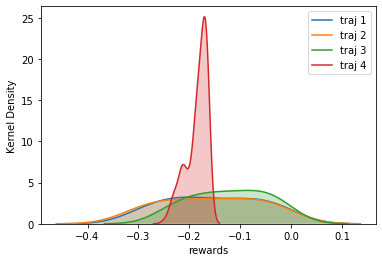

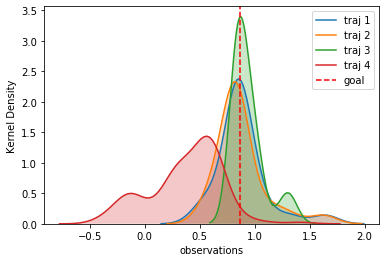

In [8]:
traj_histo(all_paths_traj_sparse[1][:5], param = 'rewards')
plt.figure()
traj_histo(all_paths_traj_sparse[1][:5], param = 'observations', var_idx=1)

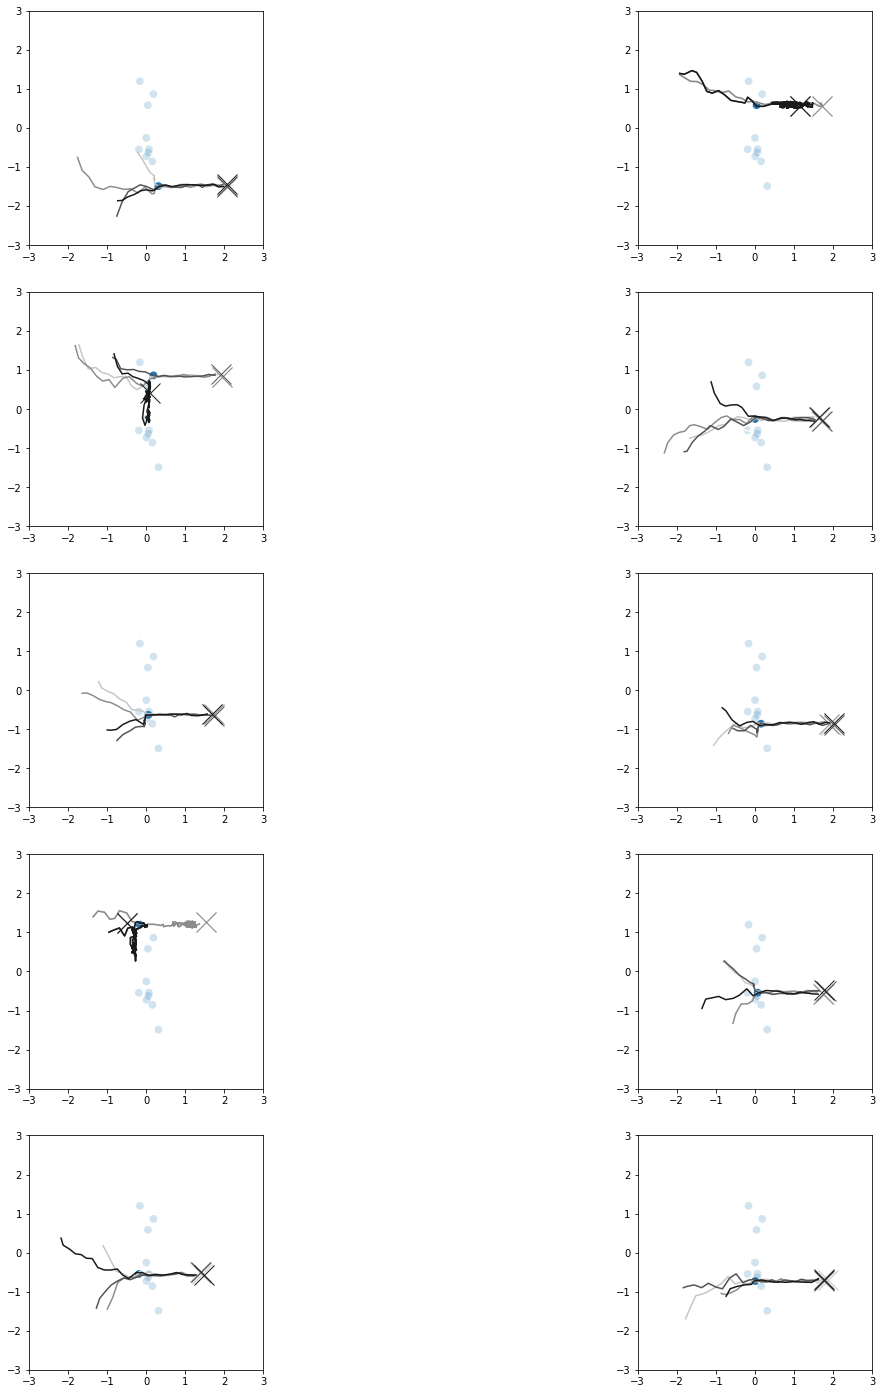

In [9]:
plot_trajectories(all_paths = all_paths_traj_sparse, num_trajs = 5)

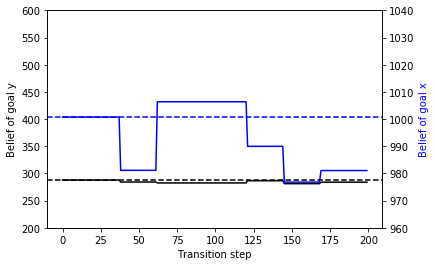

In [13]:
belief_plot(all_paths_traj_sparse[9])